# Convolutional Neural Networks with TensorFlow

"Deep Learning" is a general term that usually refers to the use of neural networks with multiple layers that synthesize the way the human brain learns and makes decisions. A convolutional neural network is a kind of neural network that extracts *features* from matrices of numeric values (often images) by convolving multiple filters over the matrix values to apply weights and identify patterns, such as edges, corners, and so on in an image. The numeric representations of these patterns are then passed to a fully-connected neural network layer to map the features to specific classes.

There are several commonly used frameworks for creating CNNs. In this notebook, we'll build a simple example CNN using TensorFlow. The example is a classification model that can classify an image as a circle, a triangle, or a square.

## Install and import libraries

First, let's install and import the TensorFlow libraries we'll need.

In [1]:
!pip install --upgrade tensorflow

  Using cached tensorflow-2.3.1-cp36-cp36m-win_amd64.whl (342.5 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Using cached tensorboard-2.3.0-py3-none-any.whl (6.8 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached h5py-2.10.0-cp36-cp36m-win_amd64.whl (2.4 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorboard_plugin_wit-1.7.0-py3-none-any.whl (779 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:


ERROR: rasa 1.10.1 has requirement prompt-toolkit<3.0,>=2.0, but you'll have prompt-toolkit 1.0.18 which is incompatible.
ERROR: rasa 1.10.1 has requirement ruamel.yaml<0.17,>=0.16, but you'll have ruamel-yaml 0.15.35 which is incompatible.
ERROR: rasa 1.10.1 has requirement tensorflow<2.2,>=2.1, but you'll have tensorflow 2.3.1 which is incompatible.
ERROR: rasa 1.10.1 has requirement tensorflow-estimator==2.1.0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
ERROR: rasa-x 0.28.3 has requirement ruamel.yaml<0.17,>=0.16, but you'll have ruamel-yaml 0.15.35 which is incompatible.
ERROR: rasa-x 0.28.3 has requirement tensorflow-estimator<2.2.0,>=2.1.0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\tensorflow_estimator-2.1.0.dist-info\\INSTALLER'
Consider using the `--user` option or check the permissions.

You

In [2]:
import tensorflow
from  tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 2.1.0
Keras version: 2.2.4-tf


## Prepare the data

Before we can train the model, we need to prepare the data. We'll divide the feature values by 255 to normalize them as floating point values between 0 and 1, and we'll split the data so that we can use 70% of it to train the model, and hold back 30% to validate it. When loading the data, the data generator will assing "hot-encoded" numeric labels to indicate which class each image belongs to based on the subfolders in which the data is stored. In this case, there are three subfolders - *circle*, *square*, and *triangle*, so the labels will consist of three *0* or *1* values indicating which of these classes is associated with the image - for example the label [0 1 0] indicates that the image belongs to the second class (*square*).

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_folder = 'data/shapes'
img_size = (128, 128)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)

Getting Data...
Preparing training dataset...
Found 840 images belonging to 3 classes.
Preparing validation dataset...
Found 360 images belonging to 3 classes.
class names:  ['circle', 'square', 'triangle']


## Define the CNN

Now we're ready to create our model. This involves defining the layers for our CNN, and compiling them for multi-class classification.

In [4]:
# Define a CNN classifier network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we;ll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution, max pooling, and dropout layer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# And another set
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.2))

# Now we'll flatten the feature maps and generate an output layer with a predicted probability for each class
model.add(Flatten())
model.add(Dense(train_generator.num_classes, activation='sigmoid'))

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 123, 32)      3488      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        36896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        36896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0

## Train the model

With the layers of the CNN defined, we're ready to train the model using our image data. In the example below, we use 5 iterations (*epochs*) to train the model in 30-image batches, holding back 30% of the data for validation. After each epoch, the loss function measures the error (*loss*) in the model and adjusts the weights (which were randomly generated for the first iteration) to try to improve accuracy. 

> **Note**: We're only using 5 epochs to minimze the training time for this simple example. A real-world CNN is usually trained over more epochs than this. CNN model training is processor-intensive, involving a lot of matrix and vector-based operations; so it's recommended to perform this on a system that can leverage GPUs, which are optimized for these kinds of calculation. This will take a while to complete on a CPU-based system - status will be displayed as the training progresses.

In [5]:
# Train the model over 5 epochs using 30-image batches and using the validation holdout dataset for validation
num_epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 28 steps, validate for 12 steps
Epoch 1/5
28/28 [==============================] - 42s 1s/step - loss: 0.8064 - accuracy: 0.5821 - val_loss: 0.4150 - val_accuracy: 0.8111
Epoch 2/5
28/28 [==============================] - 42s 1s/step - loss: 0.3708 - accuracy: 0.8274 - val_loss: 0.1924 - val_accuracy: 0.9389
Epoch 3/5
28/28 [==============================] - 41s 1s/step - loss: 0.1609 - accuracy: 0.9393 - val_loss: 0.0657 - val_accuracy: 0.9778
Epoch 4/5
28/28 [==============================] - 40s 1s/step - loss: 0.0395 - accuracy: 0.9893 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 5/5
28/28 [==============================] - 42s 1s/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9972


## View the loss history

We tracked average training and validation loss history for each epoch. We can plot these to verify that loss reduced as the model was trained, and to detect *overfitting* (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase).

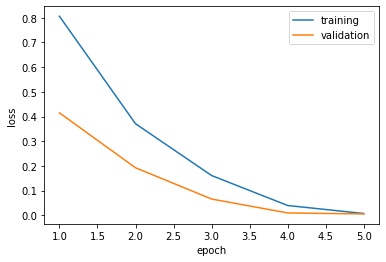

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Evaluate model performance

We can see the final accuracy based on the test data, but typically we'll want to explore performance metrics in a little more depth. Let's plot a confusion matrix to see how well the model is predicting each class.

Generating predictions from validation data...


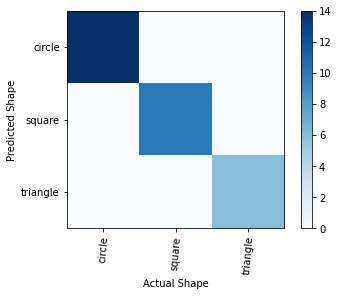

In [7]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Actual Shape")
plt.ylabel("Predicted Shape")
plt.show()

## Use the trained model

Now that we've trained the model, we can use it to predict the class of a new image.

square


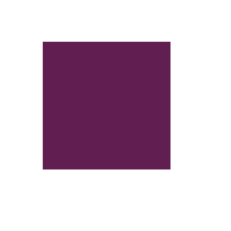

In [8]:
from tensorflow.keras import models
from random import randint
import os
%matplotlib inline

# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Save the trained model
modelFileName = 'models/shape_classifier.h5'
model.save(modelFileName)
del model  # deletes the existing model variable

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
img = create_image ((128,128), classnames[randint(0, len(classnames)-1)])
plt.axis('off')
plt.imshow(img)

# The model expects a batch of images as input, so we'll create an array of 1 image
imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

# We need to format the input to match the training data
# The generator loaded the values as floating point numbers
# and normalized the pixel values, so...
imgfeatures = imgfeatures.astype('float32')
imgfeatures /= 255

# Use the classifier to predict the class
model = models.load_model(modelFileName) # loads the saved model
class_probabilities = model.predict(imgfeatures)
# Find the class predictions with the highest predicted probability
class_idx = np.argmax(class_probabilities, axis=1)
print (classnames[int(class_idx[0])])

In this notebook, you used Tensorflow to train an image classification model based on a convolutional neural network.